# Dynamic Pricing Strategy

Ever noticed how prices on apps like Uber or Amazon seem to change all the time? That's because of a strategy called Dynamic Pricing. It's all about adjusting prices based on what customers are willing to pay. This strategy is used in many industries, from ride-hailing to online shopping, to boost profits by finding the best price for maximum demand, revenue, or profit, depending on the company's objective.

In this article, we'll dive into how dynamic pricing works, focusing on three methods:

- Rule Based Dynamic Pricing
- Using a Multi-Armed Bandit (MAB)
- Contextual Bandit to consider other factors that affect demand

In [45]:
import pandas as pd
import numpy as np
import math 

import matplotlib.pyplot as plt
import seaborn as sns

# 2. Multi-Armed Bandit (MAB)

## 2.1. Theory

Imagine you're in a casino facing several slot machines (bandits), each with its own unknown payout rate. You want to figure out which machine gives the highest payout, but you can only play one machine at a time.
The challenge is to decide which machines to play to maximize your total winnings over many rounds. You can try different machines to learn their payout rates (exploration), but you also want to stick to the best machine you've found so far to win more (exploitation). 

This problem is called the **"multi-armed bandit" problem**, where you're trying to balance exploring new options and exploiting the best option you've found to maximize your rewards. 

In the context of dynamic pricing for a ride-hailing app like Gojek, the MAB algorithm could be used to determine the best price to offer to users in real-time. Each "arm" represents a different price point, and the algorithm learns over time which price point leads to the most bookings or revenue.

There are several algorithms we can use under MAB as follow:

- **Epsilon-Greedy ($\epsilon \text{ Greedy}$)**: Balances exploration (trying out different options) and exploitation (choosing the best-known option) by introducing a parameter called epsilon (ε).
- **Upper Confident Bound (UCB)**  Balances exploration and exploitation by choosing actions based on their estimated value and uncertainty.
- **Thompson Sampling**: Probabilistic approach that uses Bayesian inference to balance exploration and exploitation.

### 2.1.1. Epsilon-Greedy ($\epsilon$ Greedy)

#### 2.1.1.1. Mathematical Notation

Let $Q(a)$ be the estimated value of action $a$, and $N(a)$ be the number of times action $a$ has been selected. The algorithm can be defined as:

1. **Initialization:** Initialize $Q(a)$ and $N(a)$ for all actions $a$.

2. **Action Selection:** At each time step $t$, with probability $\epsilon$ choose a random action $A_t$, and with probability $1 - \epsilon$ choose the action with the highest estimated value:

$
A_t = \begin{cases} 
\text{random action} & \text{with probability } \epsilon \\
\underset{a}{\text{argmax}}\ Q(a) & \text{with probability } 1 - \epsilon
\end{cases}
$

3. **Updating Estimates:** After selecting action $A_t$ and receiving reward $R_t$, update the estimate $Q(A_t)$ using the sample-average method:

$Q(A_t) \leftarrow Q(A_t) + \frac{1}{N(A_t)} (R_t - Q(A_t))$

4. **Adjusting Epsilon (optional):** You can decrease $\epsilon$ over time to shift from exploration to exploitation, for example, using a decay function like $\epsilon_t = \frac{1}{t}$ or $\epsilon_t = \epsilon_0 \times \text{exp}(-\alpha t)$, where $\epsilon_0$ is the initial epsilon value and $\alpha$ is a decay rate.

#### 2.1.1.2. Example

Let's say you have 3 slot machines (arms), and you start with no information about which one is the best.

1. At the beginning, you randomly choose one of the machines and pull its arm. Let's say you get a reward of 1.

2. Now, you update your estimate of the value of that machine using the formula: $Q(A_t) = Q(A_t) + \frac{1}{N(A_t)} (R_t - Q(A_t))$

3. Let's assume you set $\epsilon = 0.2$, which means you **explore 20% of the time and exploit 80% of the time**.

4. For the exploitation part, you choose the machine with the highest estimated value (reward so far) most of the time. So, if after a few pulls, one machine has an estimated value of 0.5, another has 0.4, and the last one has 0.3, you would choose the first machine 80% of the time.

5. For the exploration part, you randomly choose one of the machines 20% of the time, regardless of their estimated values.

This way, the algorithm balances between exploring (trying out different machines) and exploiting (choosing the best-known machine) to maximize your total rewards over time.

### 2.1.2. Upper Confident Bound

#### 2.1.2.1. Mathematical Notation

1. **Initialization**: Initialize estimates of the mean reward for each arm and a counter for the number of times each arm has been selected.

2. **Action Selection**: At each time step $t$, for each arm $a$, calculate the Upper Confidence Bound for that arm:

   $UCB(a) = \hat{Q}(a) + c \times \sqrt{\frac{\log(t)}{N(a)}}$

   where:
   - $\hat{Q}(a)$ is the estimated mean reward of arm $a$,
   - $N(a)$ is the number of times arm $a$ has been selected,
   - $t$ is the total number of time steps so far, and
   - $c$ is a parameter that controls the balance between exploration and exploitation. A common choice for $c$ is to set it to a value that depends on the problem, such as $c = \sqrt{2}$.

   Select the arm with the highest Upper Confidence Bound:

   $A_t = \underset{a}{\text{argmax}}\ UCB(a)$

3. **Reward Observation**: Observe the reward $R_t$ for the chosen arm $A_t$.

4. **Update Estimates**: Update the estimated mean reward for the chosen arm:

   $\hat{Q}(A_t) \leftarrow \frac{\hat{Q}(A_t) \times N(A_t) + R_t}{N(A_t) + 1}$

   Update the counter for the chosen arm:

   $N(A_t) \leftarrow N(A_t) + 1$

5. **Repeat steps** 2-4 for each time step.

The UCB algorithm uses the Upper Confidence Bound to select actions that are likely to have high rewards but also explores actions that have uncertain estimates. Over time, as more data is collected, the algorithm tends to favor actions that have higher estimated rewards.

#### 2.1.2.2. Example

Let's consider a scenario where you are running an online advertising campaign with three different ads (arms) and you want to maximize the click-through rate (CTR) of the ads. You decide to use the Upper Confidence Bound (UCB) algorithm to determine which ad to display to users.

1. **Initialization**: Initialize the estimated mean CTR for each ad and the number of times each ad has been selected.

2. **Action Selection**: At each time step, calculate the Upper Confidence Bound for each ad using the UCB formula:

   $UCB(a) = \hat{Q}(a) + c \times \sqrt{\frac{\log(t)}{N(a)}}$

   Let's assume $c = \sqrt{2}$ for this example. Choose the ad with the highest Upper Confidence Bound:

   $A_t = \underset{a}{\text{argmax}}\ UCB(a)$

3. **Reward Observation**: Assume that for each time step, the selected ad either results in a click (reward = 1) or no click (reward = 0).

4. **Update Estimates**: Update the estimated mean CTR for the selected ad and increment the selection counter for that ad:

   $\hat{Q}(A_t) \leftarrow \frac{\hat{Q}(A_t) \times N(A_t) + R_t}{N(A_t) + 1}$

   $N(A_t) \leftarrow N(A_t) + 1$

5. **Repeat steps** 2-4 for each time step.

Over time, the UCB algorithm will learn which ad has the highest estimated CTR and will tend to select that ad more often, while still exploring the other ads to gather more information and refine its estimates. This approach allows you to maximize the CTR of your ads by balancing exploration and exploitation.

### 2.1.3. Thompson Sampling

#### 2.1.3.1. Mathematical Notation

1. **Initialization**: Initialize prior distributions for the reward probabilities of each arm. For simplicity, let's assume Beta distributions for each arm with parameters $\alpha$ and $\beta$.

2. **Action Selection**: At each time step $t$, sample a value $\theta_a$ for each arm $a$ from its Beta distribution:

  $\theta_a \sim \text{Beta}(\alpha_a, \beta_a)$

3. Choose the arm with the highest sampled value:

  $A_t = \underset{a}{\text{argmax}}\ \theta_a$

4. **Reward Observation**: Observe the reward $R_t$ for the chosen arm $A_t$.

5. **Update**: Update the parameters of the Beta distribution for the chosen arm based on the observed reward:

  $\alpha_{A_t} \leftarrow \alpha_{A_t} + R_t$
  
  $\beta_{A_t} \leftarrow \beta_{A_t} + (1 - R_t)$

6. **Repeat steps** 2-5 for each time step.

Thompson Sampling leverages the uncertainty in the estimated reward probabilities (captured by the Beta distribution) to balance exploration and exploitation. Arms with higher uncertainty are explored more, while arms with higher expected rewards are exploited more.

While beta distributions are commonly used for rewards in dynamic pricing, they aren't the only option. If you're specifically interested in modeling the number of demands at different price points, other distributions might be a better fit. For example, gamma distributions can capture the non-negative nature of demand (unlike beta distributions) and can be shaped to reflect different demand patterns.

#### 2.1.3.2. Example

Here's an example of the first few steps:

1. **Initialization**: Assume you start with a beta distribution for each arm. Let's say for simplicity that all arms start with a Beta(1, 1) distribution, which is a uniform distribution between 0 and 1.

2. **First Pulls**:
   - Sample from each arm's distribution: Arm 1 (Beta(1, 1)) gives 0.2, Arm 2 (Beta(1, 1)) gives 0.5, Arm 3 (Beta(1, 1)) gives 0.8.
   - Select Arm 3 (highest sampled value).
   - Pull Arm 3, observe reward of 1.
   - Update Arm 3's distribution to Beta(2, 1).
   
3. **Second Pulls**:
   - Sample from each arm's distribution: Arm 1 (Beta(1, 1)) gives 0.6, Arm 2 (Beta(1, 1)) gives 0.3, Arm 3 (Beta(2, 1)) gives 0.4.
   - Select Arm 1 (highest sampled value).
   - Pull Arm 1, observe reward of 0.
   - Update Arm 1's distribution to Beta(1, 2).

This process continues, with Thompson Sampling adaptively exploring and exploiting based on the uncertainty in the estimated reward probabilities.

# 2.2. MAB Hands-on Experience

### 2.2.1. Dynamic Pricing with MAB

#### 2.2.1.1. Dataset

The dataset we will use for this exercise is sales transaction data set of UK-based e-commerce (online retail) **for one year**, taken from <a href='https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business'>kaggle</a>.

In [2]:
!kaggle datasets download -d gabrielramos87/an-online-shop-business -p dataset
!unzip dataset/an-online-shop-business.zip -d dataset

an-online-shop-business.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dataset/an-online-shop-business.zip
replace dataset/Sales Transaction v.4a.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [46]:
df = pd.read_csv('dataset/Sales Transaction v.4a.csv')
df.head()

TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country  
0  21.47        12     17490.0  United Kingdom  
1  10.65        36     13069.0  United Kingdom  
2  11.53        12     13069.0  United Kingdom  
3  10.65        12     13069.0  United Kingdom  
4  11.94         6     13069.0  United Kingdom

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


The dataset shows several columns, including:
- TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
- Date (numeric): the date when each transaction was generated.
- ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
- Product (categorical): product/item name.
- Price (numeric): the price of each product per unit in pound sterling (£).
- Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
- CustomerNo (categorical): a five-digit unique number that defines each customer.
- Country (categorical): name of the country where the customer resides.

In [48]:
print('number of products in the transactions:', df['ProductNo'].nunique())

number of products in the transactions: 3768


In [49]:
print('top 10 products with the highest number of transactions:')
print('-----')
print(df['ProductNo'].value_counts().sort_values(ascending=False).head(10))

top 10 products with the highest number of transactions:
-----
85123A    2378
22423     2200
85099B    2159
47566     1727
20725     1639
84879     1501
22197     1476
22720     1473
21212     1385
20727     1350
Name: ProductNo, dtype: int64


#### 2.2.2.2. Dataset Cleaning

In [50]:
# filter out canceled transactions

df['Canceled'] = ['Yes' if 'C' in x else 'No' for x in df['TransactionNo']]
print('number of canceled transaction:', len(df[df['Canceled'] == 'Yes']))

df = df[df['Canceled'] == 'No']
df.head()

number of canceled transaction: 8585


TransactionNo       Date ProductNo                          ProductName  \
0        581482  12/9/2019     22485        Set Of 2 Wooden Market Crates   
1        581475  12/9/2019     22596  Christmas Star Wish List Chalkboard   
2        581475  12/9/2019     23235             Storage Tin Vintage Leaf   
3        581475  12/9/2019     23272    Tree T-Light Holder Willie Winkie   
4        581475  12/9/2019     23239    Set Of 4 Knick Knack Tins Poppies   

   Price  Quantity  CustomerNo         Country Canceled  
0  21.47        12     17490.0  United Kingdom       No  
1  10.65        36     13069.0  United Kingdom       No  
2  11.53        12     13069.0  United Kingdom       No  
3  10.65        12     13069.0  United Kingdom       No  
4  11.94         6     13069.0  United Kingdom       No

#### 2.2.2.3. Exploratory Data Analysis (EDA)

At this step, we will explore the dataset we have. After that, based on the data specification, we will choose which product should we use for the MAB analysis.

In [51]:
def product_transformation(df, product_no, cnt_trx):
    df_analyze = df[df['ProductNo'] == product_no].groupby('Price').agg(
        mean_qty=('Quantity', 'mean'),
        median_qty=('Quantity', 'median'),
        cnt_trx=('TransactionNo', 'size')
    )

    df_analyze['mean_qty'] = df_analyze['mean_qty'].map(math.ceil)
    df_analyze['median_qty'] = df_analyze['median_qty'].map(int)

    df_analyze = df_analyze[df_analyze['cnt_trx'] > cnt_trx]

    return df_analyze

In [52]:
analyze_dict = {}

for product in df['ProductNo'].value_counts().sort_values(ascending=False).head(10).index:
    df_analyze = product_transformation(df, product, 30)
    analyze_dict[product] = df_analyze
    
    print('Cleaned product data for:', product)
    print('-----')
    display(df_analyze)

Cleaned product data for: 85123A
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19         16           4       88
7.24         15           6       38
12.86        56          32      334
13.27         7           6     1619
16.18         3           1      139
17.05         3           2       53

Cleaned product data for: 85099B
-----


mean_qty  median_qty  cnt_trx
Price                               
5.97        142         100       65
6.04        134         100      137
6.13         13          10      335
6.19         12          10     1074
7.24          5           2      429
7.29          3           2       43

Cleaned product data for: 22423
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19          6           2       66
21.47        28          16      296
23.32         3           2     1366
35.83         4           2      185
36.38         9           2       32

Cleaned product data for: 47566
-----


mean_qty  median_qty  cnt_trx
Price                               
14.50        68          50      102
15.02         6           5       71
15.32         6           4     1191
21.31        12           3      221

Cleaned product data for: 20725
-----


mean_qty  median_qty  cnt_trx
Price                               
5.87         98         100       64
5.97         10          10     1190
6.19         11          10       44
7.24          3           1      158
7.67         15           8       80

Cleaned product data for: 84879
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19         30          16       61
11.74       257         160       48
11.98        17          10     1297

Cleaned product data for: 22197
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19         42          15       89
7.24         48          38       34
10.99       224         100      129
11.12        15          12      820
11.92         7           4      259
11.95        13           8       46

Cleaned product data for: 22720
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19          4           3       43
14.61        40          24       56
15.32         4           3     1068
21.31         2           1      174

Cleaned product data for: 21212
-----


mean_qty  median_qty  cnt_trx
Price                               
6.19         14          11       36
10.68       181         120       66
10.81        19          24      965
11.53         2           1      162
12.38        20          16       67

Cleaned product data for: 20727
-----


mean_qty  median_qty  cnt_trx
Price                               
5.87         90         100       32
5.97          8          10     1006
6.19          7           2       60
7.24          3           1      114
7.67          9           6       71

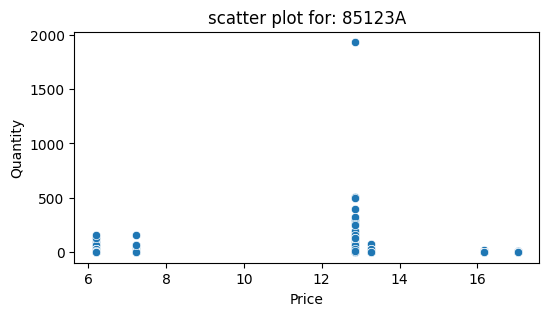

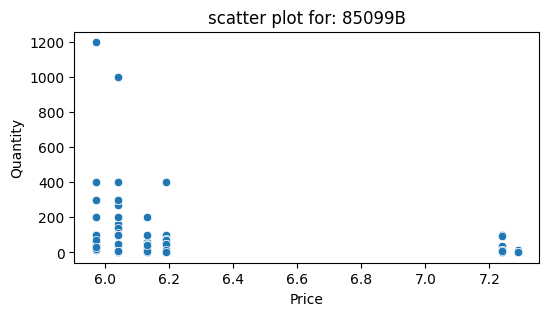

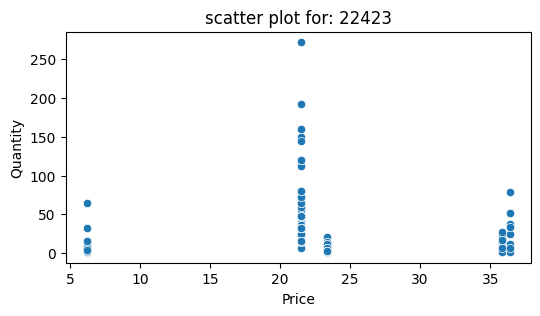

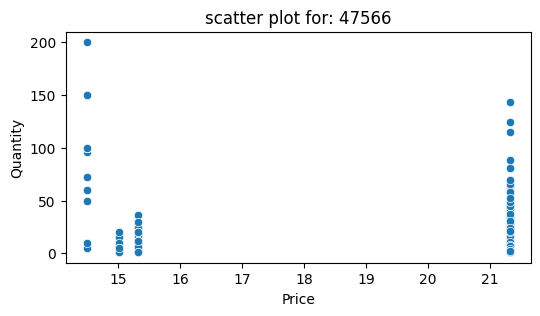

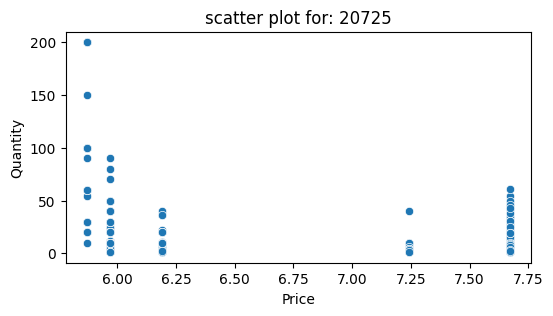

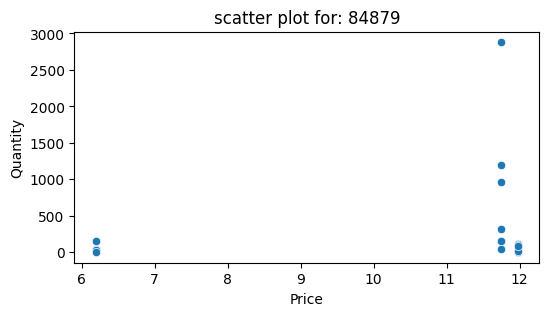

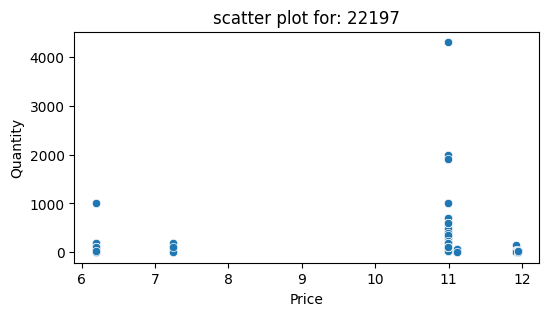

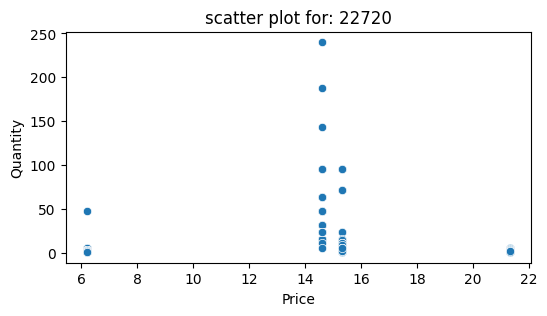

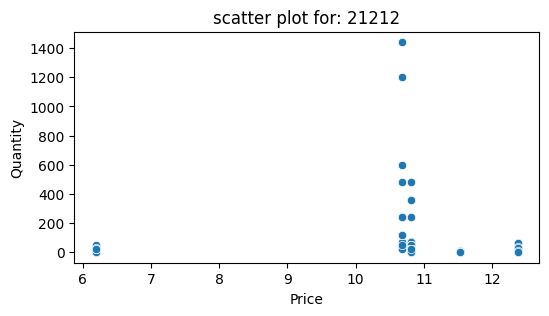

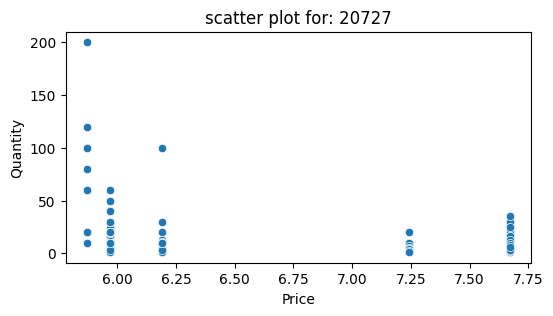

In [53]:
for product in analyze_dict.keys():

    plt.figure(figsize=(6,3))

    df_analyze = analyze_dict[product]
    df_plot = df[(df['ProductNo'] == product) & (df['Price'].isin(df_analyze.index))][['Price', 'Quantity']]

    sns.scatterplot(x=df_plot['Price'], y=df_plot['Quantity'])
    plt.title('scatter plot for: ' + product)
    plt.show()

Based on the outcome shown, we can utilize product number **85099B and 20725** as it follows the normal demand curve (sloping downwards).

#### 2.2.2.4. Analysis Using Thompson Sampling

Let's start by analyzing product number 85099B. However, we don't have the data of the COGS (variable cost + fixed cost). The data of cost is very useful for us when it comes to maximizing the profit. As you can see from the profit formula below:

$Profit = p * D(p) - (var\_cost*D(p) + fixed\_cost)$

One last thing we have to know about is the **constant-elasticity demand function**. It is a mathematical representation of the relationship between quantity demanded (Q) and price (P) that is commonly used in economics. The formula is derived from economic theory and assumptions about consumer behavior. 

- **Assumptions**: The formula is derived based on the assumption that consumers make rational decisions to maximize their utility (satisfaction) subject to their budget constraints. It also assumes that consumers have a consistent preference ordering for goods and services.

- **Utility Maximization**: In this framework, consumers choose the quantity of goods and services to consume in such a way that the marginal utility (additional satisfaction) per dollar spent is equal for all goods and services. This leads to the concept of the elasticity of demand, which measures the responsiveness of quantity demanded to changes in price.

- **Elasticity of Demand**: The parameter \( \epsilon \) in the formula represents the price elasticity of demand, which measures the percentage change in quantity demanded in response to a one percent change in price. The elasticity of demand is assumed to be constant along the demand curve in this model, hence the term "constant-elasticity demand function".

- **Empirical Validation**: While the constant-elasticity demand function is derived from economic theory, its applicability and accuracy in real-world situations are often tested empirically using data analysis and statistical methods. Researchers and economists use historical data on prices and quantities to estimate the parameters of the demand function and assess its predictive power.

Thus, the formula is shown as follow:

$D(p) = ap^{-\eta}$

With... 
- $D(p)$ represents the quantity demanded as a function of price (p)
- $a$ as shape / constant parameter 
- $p$ captures price of the good or service, with the higher values of p typically correspond to lower quantity demanded
- Price elasticity $\eta$

<figure>
    <img src='images/constant-elasticity demand function example.png' alt='constant-elasticity demand function example' width=600>
    <figcaption>Example of constant-elasticity demand curve fitted to the data</figcaption>
</figure>

Why do we need that in the first place? We will use this as the **prior for our Multi-Armed Bandit by the Thompson Sampling algorithm**. If this doesn't sound make sense for you, we will explore more after this.

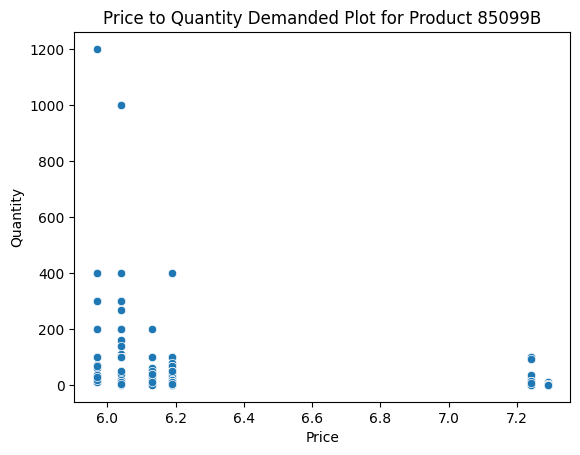

In [54]:
product_no = '85099B'

df_analyze = df[df['ProductNo'] == product_no]
df_analyze = df_analyze[['Price', 'Quantity']]
df_analyze = df_analyze[df_analyze['Price'].isin(analyze_dict[product_no].index)]

sns.scatterplot(data=df_analyze, x='Price', y='Quantity')
plt.title(f'Price to Quantity Demanded Plot for Product {product_no}')
plt.show()

Now, let's set the prior for the quantity demanded. These priors are semi-informed because we have the prior knowledge that price elasticity is most likely between 0 and 1. As for the other parameters, we have little knowledge about them so we can place a pretty uninformative prior.

- $a \sim N(\mu=0, \sigma=2)$
- $\eta \sim N(\mu=0.5, \sigma=0.5)$
- $sd \sim Exp(\lambda = 1)$
- $D|P = p \sim N(\mu = ap^{-\eta}, \sigma=sd)$

You might wonder why did we set these values in the parameters? Even though there's no strict rules about it, we can put these uninformative prior for these reasons.

Let's start from the $a$ value first:
- Setting $\mu=0$ for a creates a symmetrical normal distribution centered around 0. This can be a good starting point if you don't have strong prior knowledge about the underlying factor a represents. It allows a to take on both positive and negative values, potentially capturing different effects on price elasticity.
- Setting $\sigma=2$ allows for more flexibility in the distribution of a. A wider standard deviation allows a to vary across a wider range, which can be beneficial if the factor it represents can have a significant positive or negative influence on price elasticity.

$\eta$ value:
- A mean of 0.5 could reflect some prior belief that the price elasticity is more likely to be negative (due to the negative exponent in the formula for μ in equation 4).
- A standard deviation of 0.5 allows for η to deviate from the mean value, capturing some uncertainty about the exact elasticity.

$sd$ value:
- The exponential distribution with lambda=1 has no specific memory and doesn't depend on past values. 
- It might represent some general uncertainty or variability around the price elasticity that's independent of a and η.

Now, let's implement it to the code. In Thompson sampling, a new demand curve (and consequently a price point) is sampled from the posterior distribution for each iteration. After applying the price to our data and obtaining the demand quantity, this quantity is used to update the posterior distribution as the next prior for our data. This approach would be suitable in the real life case, where we're seeking for the balance between exploration and exploitation.

Check the code below:

#### 1. **Initialization**

Start by setting priors for the model parameters (e.g., demand curve parameters) based on your prior knowledge or assumptions. Here we have set the prior knowledge based on constant-demand elasticity function. We already have the data as well to update our prior. Thus, we will update our prior first based on the observed (price to demand) data that we have.

Important thing to note! If we haven't the data yet, we can just define the model without putting the observed data. In that case, you don't have to follow the steps below and you can go straight to the next step.

In [88]:
from sklearn.model_selection import train_test_split

# here, we will split the data into two, one to update the posterior here and another to do the incremental update
prior_data, inc_update_data = train_test_split(df_analyze, test_size=0.5)

In [90]:
import pymc as pm

price = prior_data['Price'].values          # enter the price we have set before
demand = prior_data['Quantity'].values      # enter the demand at each price point

with pm.Model() as model:
    # define prior for a, price elasticity (eta), and sd
    a = pm.Normal('a', mu=0, sigma=2)
    eta = pm.Normal('eta', mu=0.5, sigma=0.5)
    sd = pm.Exponential('sd', lam=1)

    # price elasticity function, as the mean for our demand function 
    def price_elasticity(p, a=a, eta=eta):
        mu = a * p ** -eta
        return mu

    # update posterior based on the demand data we have
    # pass price to the price_elasticity, and demand observed to the D
    D = pm.Normal('D', mu=price_elasticity(price), sigma=sd, observed=demand)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, eta, sd]
/Users/taufiqurrohman/anaconda3/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/taufiqurrohman/anaconda3/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


#### 1.1. Investigation of the Result

In [232]:
trace.mean()['posterior']['a'].values.item()

5.11618141349094

In [233]:
trace.posterior['a'].values.flatten()

array([3.79838832, 4.31105252, 4.31105252, ..., 6.45918899, 4.89441909,
       3.92067626])

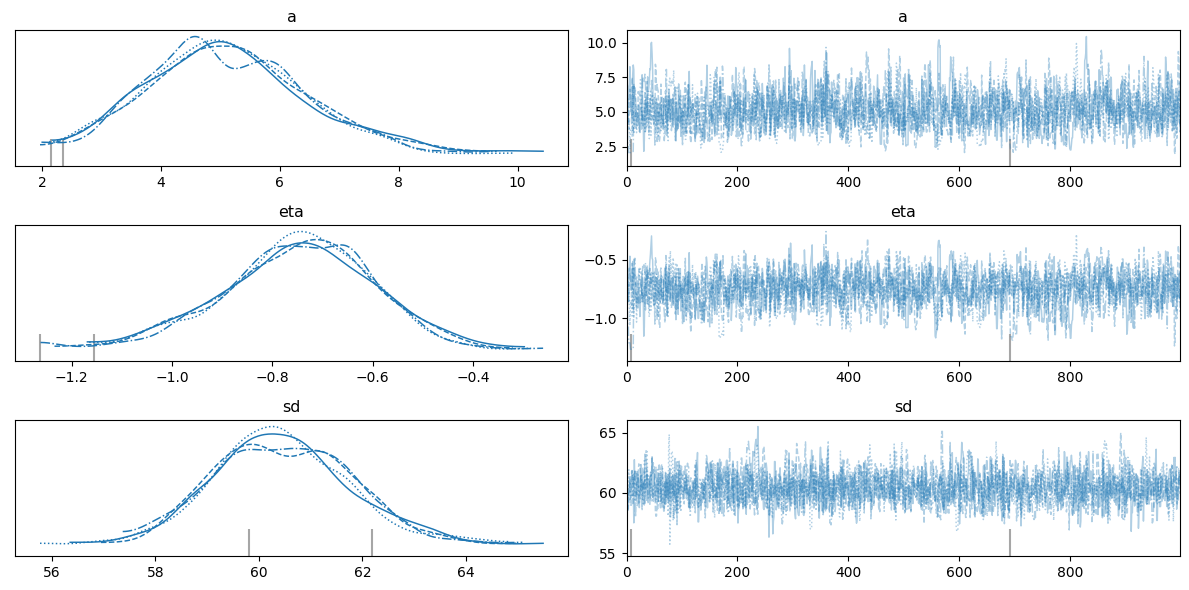

In [91]:
# plot the result

pm.plot_trace(trace)

plt.tight_layout()
plt.show()

In [92]:
a = trace.mean()['posterior']['a'].values.item()
eta = trace.mean()['posterior']['eta'].values.item()
sd = trace.mean()['posterior']['sd'].values.item()

print('updated a value from the result:', round(a, 2))
print('updated price elasticity (eta) value from the result:', round(eta, 2))
print('updated standard deviation from the result:', round(sd, 2))

updated a value from the result: 5.12
updated price elasticity (eta) value from the result: -0.75
updated standard deviation from the result: 60.45


#### 1.2. Posterior for the Demand Curve

In [138]:
# function to generate df_posterior for every single possible value of a, eta, and sd
def create_df_posterior(a, eta, sd):
    
    df_posterior = pd.DataFrame(columns=['a', 'eta', 'sd'])
    df_posterior['a'] = a
    df_posterior['eta'] = eta
    df_posterior['sd'] = sd

    return df_posterior

# next, function to generate price to demand based on a, eta, and sd value
# we can adjust price by passing the price point_value
def create_price_demand_posterior(price_point, df_posterior):

    price_demand_posterior = {}

    for i in range(len(df_posterior)):
        demand = df_posterior.loc[i, 'a'] * price_point**(df_posterior.loc[i, 'eta'])
        price_demand_posterior[i] = demand

    return price_demand_posterior

In [139]:
a = trace.posterior['a'].values.flatten()
eta = trace.posterior['eta'].values.flatten()
sd = trace.posterior['sd'].values.flatten()

df_posterior = create_df_posterior(a, eta, sd)

# create price point for the plot using np.linspace
# where it ranges from 1 to 20, with total number we want to generate between start-stop = 100
price_point = np.linspace(1, 20, 100)

price_demand_posterior = create_price_demand_posterior(price_point, df_posterior)

display(df_posterior)
display(price_demand_posterior)

a       eta         sd
0     3.798388 -0.871035  60.976710
1     4.311053 -0.805030  58.690462
2     4.311053 -0.805030  58.690462
3     4.207183 -0.857418  58.579456
4     6.837150 -0.591208  60.366103
...        ...       ...        ...
3995  5.666540 -0.725473  60.460725
3996  5.538291 -0.625290  61.234889
3997  6.459189 -0.625249  60.791160
3998  4.894419 -0.861123  60.145707
3999  3.920676 -0.779612  59.931806

[4000 rows x 3 columns]

{0: array([3.79838832, 3.2597605 , 2.86225957, 2.55610749, 2.31261178,
        2.11403408, 1.94879979, 1.80902476, 1.68914732, 1.58512816,
        1.49396063, 1.41335911, 1.34155409, 1.2771536 , 1.21904716,
        1.16633771, 1.11829241, 1.07430654, 1.03387653, 0.99657955,
        0.96205785, 0.93000668, 0.90016472, 0.87230661, 0.84623693,
        0.82178533, 0.79880267, 0.77715773, 0.75673465, 0.73743068,
        0.71915441, 0.70182419, 0.68536692, 0.66971688, 0.65481486,
        0.64060738, 0.62704598, 0.61408662, 0.60168926, 0.58981735,
        0.57843746, 0.56751899, 0.55703383, 0.54695616, 0.53726215,
        0.52792984, 0.51893894, 0.51027064, 0.50190752, 0.49383339,
        0.48603321, 0.47849296, 0.4711996 , 0.46414092, 0.45730555,
        0.45068281, 0.44426273, 0.43803593, 0.43199364, 0.4261276 ,
        0.42043003, 0.41489363, 0.4095115 , 0.40427714, 0.39918443,
        0.39422755, 0.38940104, 0.38469969, 0.38011861, 0.37565312,
        0.37129883, 0.36705152, 0.36290723, 0

In [140]:
# define the function to plot the demand curve
# in this kind of architecture for us to be able to create subplots for this graph

def plot_demand_curve(ax, price_point, price_demand_posterior, demand_mean):
    for i in price_demand_posterior.keys():
        ax.plot(price_point, price_demand_posterior[i], color='silver')
        if i == 25:
            break

    ax.plot(price_point, demand_mean, color='red')
    ax.set_ylim(0, 10)
    ax.set_title('Updated Posterior of the Demand Curve')

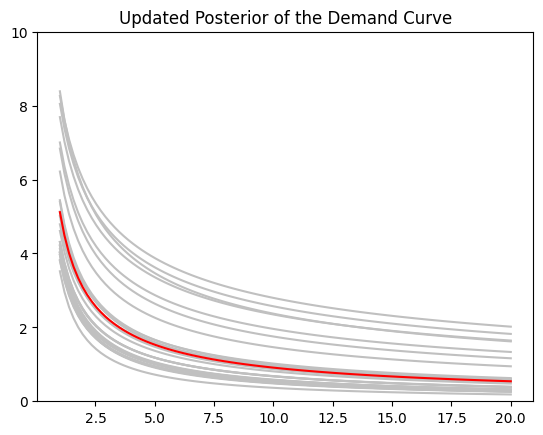

In [141]:
# we can call the function now

# for plotting the mean / most likely the demand will fall along this curve
a_mean = trace.mean().posterior['a'].values
eta_mean = trace.mean().posterior['eta'].values
sd_mean = trace.mean().posterior['sd'].values

demand_mean = a_mean * price_point**(eta_mean)

fig, ax = plt.subplots(1, 1)
plot_demand_curve(ax, price_point, price_demand_posterior, demand_mean)
plt.show()

#### 1.3. Posterior for the Profit Curve

Now, we need to make an assumption about the Cost of Goods Sold (COGS) for the products since this information is not available in the dataset. Why is this necessary? The dynamic pricing would be very useful to look the maximum profit we can get. With the optimization function, we would be able to know at what price would it give us the maximum profit. The profit is calculated as follows:

$Profit(p) = p * D(p) - [var\_cost * D(p) + fixed\_cost]$

Here, `Profit(p)` represents the profit at price p, and `D(p)` is the total demand at price p.

We will skip the fixed cost part. But for the variable cost, let's assume it's 70% of the minimum price charged to the consumer.

In [142]:
fixed_cost = 0
cogs = df_analyze['Price'].min() * 0.7

print('fixed cost is at:', fixed_cost)
print('variable cost is at:', cogs)

fixed cost is at: 0
variable cost is at: 4.178999999999999


In [171]:
def create_price_profit_posterior(price_point, fixed_cost, cogs, price_demand_posterior, df_posterior):

    price_profit_posterior = {}

    for i in range(len(df_posterior)):
        price_profit_posterior[i] = price_point * price_demand_posterior[i] - (cogs * price_demand_posterior[i] + fixed_cost)

    return price_profit_posterior

In [173]:
price_profit_posterior = create_price_profit_posterior(price_point, fixed_cost, cogs, price_demand_posterior, df_posterior)
price_profit_posterior

{0: array([-12.07507646,  -9.73716804,  -8.00047809,  -6.65416745,
         -5.57645451,  -4.69189579,  -3.95116204,  -3.32058373,
         -2.77636101,  -2.30117377,  -1.88210368,  -1.50931049,
         -1.17516073,  -0.87363756,  -0.59993128,  -0.35014872,
         -0.12110316,   0.08984024,   0.28487998,   0.46586571,
          0.6343654 ,   0.7917175 ,   0.93907184,   1.07742202,
          1.20763138,   1.33045385,   1.44655094,   1.55650563,
          1.66083382,   1.75999378,   1.85439412,   1.94440038,
          2.03034065,   2.11251026,   2.19117589,   2.26657893,
          2.33893849,   2.40845394,   2.47530709,   2.53966414,
          2.60167732,   2.66148636,   2.71921974,   2.77499587,
          2.82892399,   2.88110513,   2.93163285,   2.9805939 ,
          3.02806889,   3.07413279,   3.11885544,   3.16230199,
          3.20453328,   3.24560622,   3.28557407,   3.32448678,
          3.36239122,   3.39933139,   3.43534871,   3.47048215,
          3.50476843,   3.53824219,  

In [186]:
# define the function to plot the price-to-profit curve
# in this kind of architecture for us to be able to create subplots for this graph

def plot_price_profit_curve(ax, price_point, price_profit_posterior, demand_mean):

    profit_mean = price_point * demand_mean - (cogs * demand_mean + fixed_cost)

    for i in price_profit_posterior.keys():
        ax.plot(price_point, price_profit_posterior[i], color='silver')
        # set a limit to make the plot readable
        # we have 4,000 data points, so let's limit it at 25
        if i == 25:
            break

    ax.plot(price_point, profit_mean, color='red')

    ax.axline(xy1=(0, 0), slope=0, color='black', linestyle='--')
    ax.set_title('Updated Posterior of the Profit Curve')

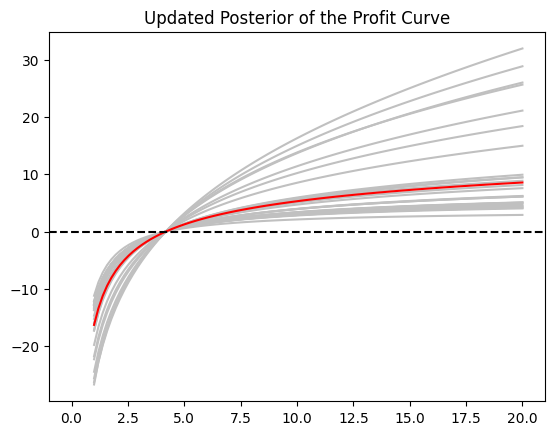

In [187]:
# we can call the function now
# for plotting the mean / most likely the profit will fall along this curve

fig, ax = plt.subplots(1, 1)
plot_price_profit_curve(ax, price_point, price_profit_posterior, demand_mean)
plt.show()

#### 1.4. Incremental Posterior Update

In using Thompson modeling, there's one key step that we have to update the posterior every single time we have new data. With pyMC, we have **two alternatives** to do this:

1. Retrain the data from the scratch
    - Will be very memory expensive if we have a lot of data and continuous from time to time
    - Estimation will be more accurate

2. Incremental posterior update
    - Not that expensive as we train the data incrementally as the date comes
    - Custom code from Stackoverflow, based on an approximation, and there hasn't been any attempts to check to what extent the errors will be
    - See the documentation <a href='https://stackoverflow.com/questions/53211277/updating-model-on-pymc3-with-new-observed-data'>here</a>.

The code below will show you on how to do the incremental posterior update.

In [98]:
import numpy as np
from scipy import stats

# first, we build a function for Kernel Density Estimated (KDE) updated priors
# yields approximations to true updated priors and would be most useful in cases where conjugate priors are not possible.

def from_posterior(param, samples, k=100):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, k)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

In [106]:
prior_a = trace.posterior['a'].values.flatten()
prior_eta = trace.posterior['eta'].values.flatten()
prior_sd = trace.posterior['sd'].values.flatten()

update_price = inc_update_data['Price'].values          # enter the price we have set before
update_demand = inc_update_data['Quantity'].values      # enter the demand at each price point

with pm.Model() as m1:
    # from the function above, we can update our a, eta, and sd parameters based on the updated posterior
    a = from_posterior('a', prior_a)
    eta = from_posterior('eta', prior_eta)
    sd = from_posterior('sd', prior_sd)

    def price_elasticity(p, a=a, eta=eta):
        mu = a * p ** -eta
        return mu

    # now, we can pass the data we sampled before to the observed parameter
    # to do the incremental update
    D = pm.Normal('D', mu=price_elasticity(update_price), sigma=sd, observed=update_demand)
    
    trace_new = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, eta, sd]
/Users/taufiqurrohman/anaconda3/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/Users/taufiqurrohman/anaconda3/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 8 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


#### 1.5. Comparison Between Prior and Posterior (Updated Prior)

In [145]:
a_updated = trace_new.posterior['a'].values.flatten()
eta_updated = trace_new.posterior['eta'].values.flatten()
sd_updated = trace_new.posterior['sd'].values.flatten()

df_posterior_updated = create_df_posterior(a_updated, eta_updated, sd_updated)
price_demand_posterior_updated = create_price_demand_posterior(price_point, df_posterior_updated)

a_mean_updated = trace_new.mean().posterior['a'].values
eta_mean_updated = trace_new.mean().posterior['eta'].values
sd_mean_updated = trace_new.mean().posterior['sd'].values

demand_mean_updated = a_mean_updated * price_point**(eta_mean_updated)

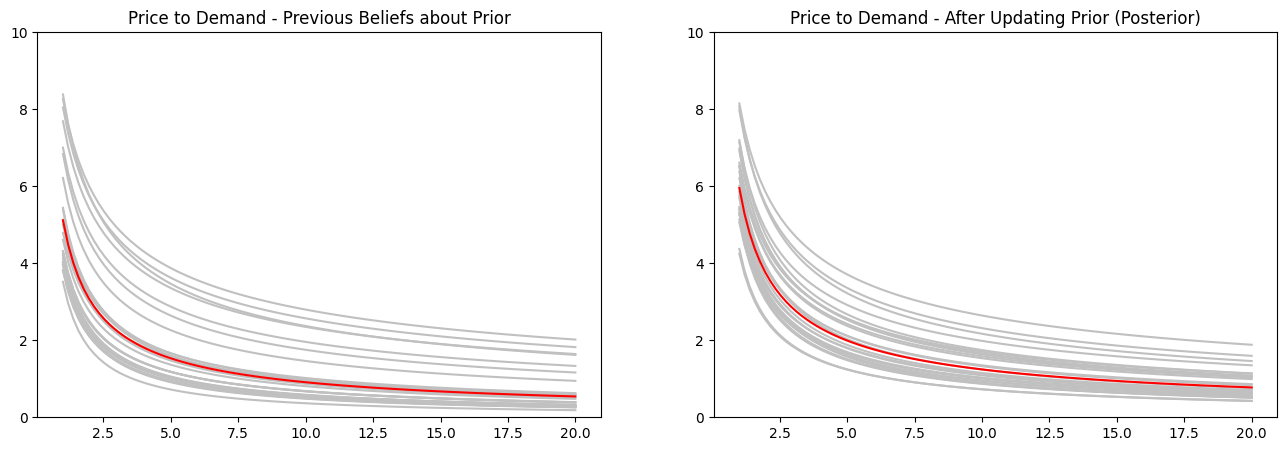

In [190]:
# we can call the function now

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

plot_demand_curve(ax1, price_point, price_demand_posterior, demand_mean)
plot_demand_curve(ax2, price_point, price_demand_posterior_updated, demand_mean_updated)

ax1.set_title('Price to Demand - Previous Beliefs about Prior')
ax2.set_title('Price to Demand - After Updating Prior (Posterior)')
plt.show()

In [180]:
price_profit_posterior_updated = create_price_profit_posterior(price_point, fixed_cost, cogs, price_demand_posterior_updated, df_posterior_updated)

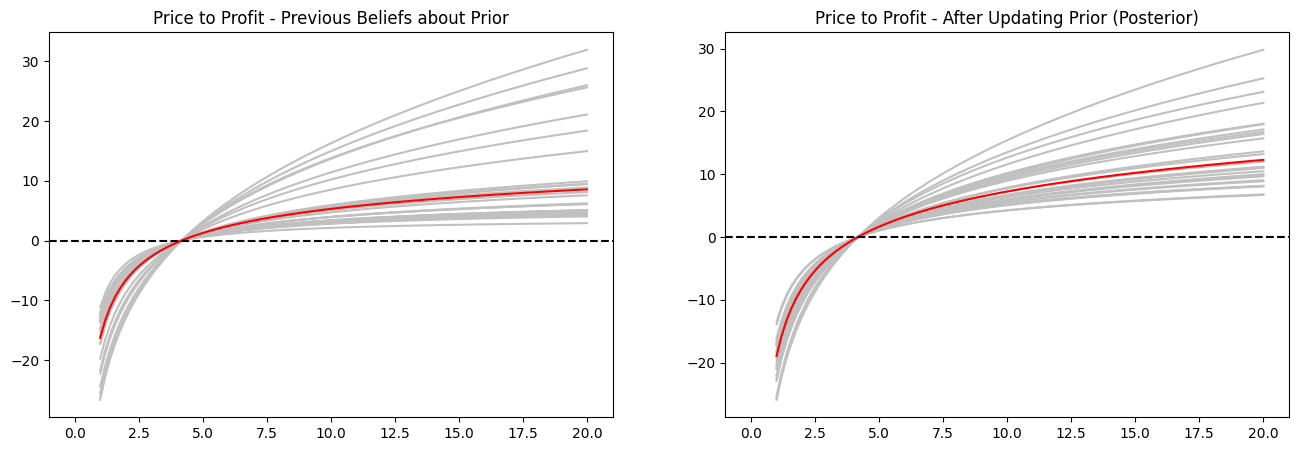

In [189]:
# we can call the function now

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

plot_price_profit_curve(ax1, price_point, price_profit_posterior, demand_mean)
plot_price_profit_curve(ax2, price_point, price_profit_posterior_updated, demand_mean_updated)

ax1.set_title('Price to Profit - Previous Beliefs about Prior')
ax2.set_title('Price to Profit - After Updating Prior (Posterior)')
plt.show()

#### 2. **Thompson Sampling Loop**

In Thompson Sampling for dynamic pricing modeling, the direct update of price priors isn't typically done. Instead, the priors for parameters like $a$, $\eta$, and $sd$ are updated based on observed rewards (profits), which indirectly affects the probability of choosing different price levels. 

This process can lead to a bias towards price levels with higher observed profits, as the updated priors for these parameters influence the demand distribution and, consequently, the expected profits at each price level. This is what Thompson Sampling for. While it favors price with higher profits during the sampling process, it also maintains exploration by sampling from the updated priors, which helps to mitigate this bias to some extent.

Then after that, we would sample the parameters $a$, $\eta$, and $sd$ from their respective prior distributions at each iteration. These sampled parameters are then used to calculate the demand distribution for each price level, which influences the selection of the price level that maximizes the expected profit.

In [213]:
index = np.random.randint(0, len(trace_new.posterior['a'].values.flatten()))

# Extract the corresponding values for 'a', 'eta', and 'sd'
a_thomp_sample = trace_new.posterior['a'].values.flatten()[index]
eta_thomp_sample = trace_new.posterior['eta'].values.flatten()[index]
sd_thomp_sample = trace_new.posterior['sd'].values.flatten()[index]

print("sampled values: a =", a_thomp_sample, ", eta =", eta_thomp_sample, ", sd =", sd_thomp_sample)

sampled values: a = 6.4680503189887055 , eta = -0.6451242345686583 , sd = 58.12449534080942


In [220]:
price_point_to_test = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

thomp_sample_df = pd.DataFrame(columns=['price', 'demand', 'profit'])

for i, price in enumerate(price_point_to_test):
    demand_thomp_sample = a_thomp_sample * price**(eta_thomp_sample)
    profit_thomp_sample = price * demand_thomp_sample - (cogs * demand_thomp_sample + fixed_cost)

    thomp_sample_df.loc[i, 'price'] = price
    thomp_sample_df.loc[i, 'demand'] = demand_thomp_sample
    thomp_sample_df.loc[i, 'profit'] = profit_thomp_sample

    thomp_sample_df = thomp_sample_df.sort_values('profit')

display(thomp_sample_df)

price    demand     profit
0     2  4.135915   -9.01216
1     4   2.64466  -0.473394
2     6   2.03596   3.707482
3     8  1.691096   6.461676
4    10  1.464364   8.524065
5    12  1.301869   10.18192
6    14  1.178633   11.57535
7    16   1.08135  12.782642
8    18  1.002228  13.851798
9    20   0.93637  14.814307

According to the dataframe above, the **highest reward (profit) is achieved when the price is set at 20**. Despite only receiving demand for 1 unit, this price point yields the highest profit compared to other price levels. Therefore, in the next iteration, we will set and investigate the demand at this price point.

#### 3. **Observation and Update**

There's no calculation in this step. Only thing you have to do is:

- Observe the demand and profit at the chosen price point (exploitation or exploration).
- Update the posterior distribution based on the observed demand.
- Repeat the Thompson Sampling loop.

#### **4. Things to be taken as a note!**

From the results, it's clear that something is off. The standard deviation we found is very high, around 58. This means that the initial prior we made about demand using constant elasticity demand model doesn't match our actual data well. In fact, in many real situations, this model doesn't work as expected. How can we fix this?

Another method called Gaussian Processes might help. Instead of forcing a specific demand pattern onto the data, it lets the data show the pattern itself. If you want to know more, you can look at the next notebook on Dynamic Pricing Modeling using Gaussian Process.